# Test Inspektor Gadget scaling

The goal of this experiment is to test until which number of nodes Inspektor Gadget scales.

## Experimental environment

### Hardware environment

Inspektor Gadget will be tested on an AKS cluster using `Standard_DS2_v2` as node Azure image (*i.e* 2 CPU cores and 7 GB of DRAM).
The number of nodes will vary over the experience with the following values: 2, 5, 11, 17, 23, 31 and 39.
The number of nodes were chosen to be one over two prime number until 39 (which is non prime though).

### Software environment

To test scaling, the idea is to deploy a pod on each nodes which will generate a lot of `exec()` and to count the number of `exec()` events reported by Inspektor Gadget.
So, on each node, a pod running `stress-ng` is deployed to generate as many `exec()` it can during 1 second on all the node CPU (in our case 2).
Before that, Inspektor gadget is deployed on the cluster to monitor all these pods (which belong to the same namespace).
The experiment is described in `script.sh`.

### Statistics

For each number of node, the above experiment is run 30 times to compute some statistics.

## Results

The results are depicted in the following graphs.
The `x` axis indicates the experiment number from 1 to 30 while the `y` axis indicates the number of `exec()`.
Each graph presents two curves:

1. One which is the sum of all `exec()` generated for all nodes.
2. The other which is the number of `exec()` reported by Inspektor Gadget.

In [74]:
!pip install pandas > /dev/null
!pip install matplotlib --upgrade > /dev/null
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline


matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

NODE_NUMBERS = [2, 5, 11, 17, 23, 31, 39]
dataframes = []

for node_nr in NODE_NUMBERS:
    df = pd.read_csv(f'exec-{node_nr}-nodes.csv')
    df['nodes-sum'] = df.filter(regex = 'node').sum(axis = 1)

    dataframes.append(df)

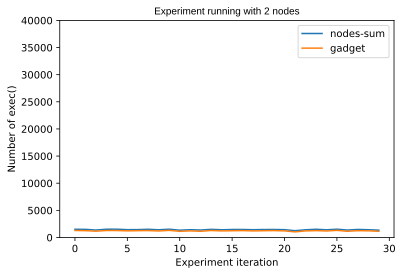

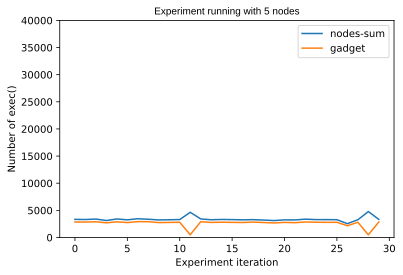

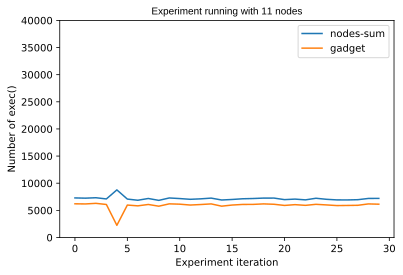

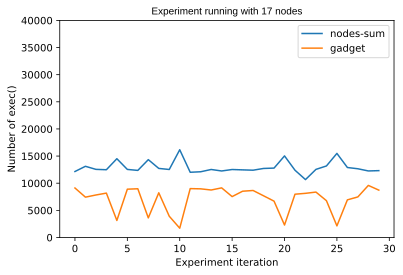

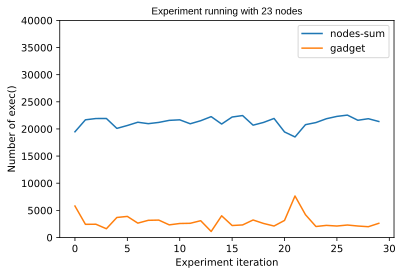

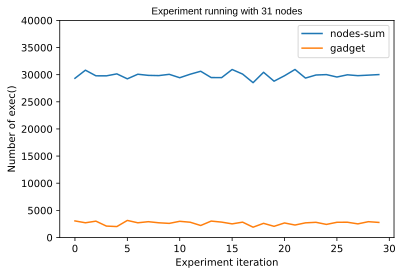

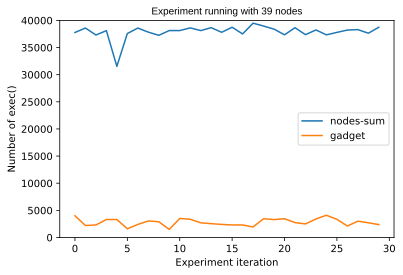

In [75]:
for i in range(len(NODE_NUMBERS)):
    dataframes[i][['nodes-sum', 'gadget']].plot()
    plt.title(f'Experiment running with {NODE_NUMBERS[i]} nodes', font='Liberation Sans')
    plt.xlabel('Experiment iteration')
    plt.ylabel('Number of exec()')
    plt.ylim(0, 40000)
    plt.show()

## Interpretation

First of all, the curves are quite flat, so we can conclude there are not so much variation across the iterations.

The number of events reported by Inspektor Gadget follows the number of `exec()` generated until the experiment involving 17 nodes.
For experiments with less than 17 nodes, Inspektor Gadget reports less events than actual number of generated `exec()`.

Let's compute the 99th percentile for all number of nodes:

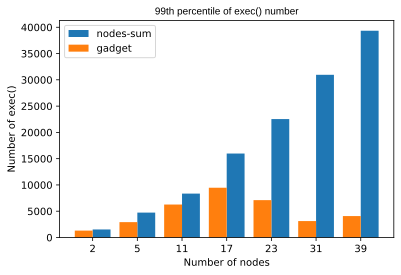

In [77]:
import numpy as np

percentiles = {'nodes-sum': [], 'gadget': []}

for i in range(len(NODE_NUMBERS)):
    # 99th percentile
    quantile = dataframes[i][['nodes-sum', 'gadget']].quantile(0.99)
    percentiles['nodes-sum'].append(quantile['nodes-sum'])
    percentiles['gadget'].append(quantile['gadget'])

df = pd.DataFrame(percentiles)
nodes_sum = df[['nodes-sum']].to_numpy().ravel()
gadget = df[['gadget']].to_numpy().ravel()

nodes_sum_fig = plt.bar(range(len(nodes_sum)), nodes_sum, align='edge', width=0.4, label='nodes-sum')
gadget_fig = plt.bar(range(len(gadget)), gadget, align='edge', width=-0.4, label='gadget')

plt.legend()
plt.xticks(np.arange(len(NODE_NUMBERS)), NODE_NUMBERS, rotation=0)
plt.xlabel('Number of nodes')
plt.ylabel('Number of exec()')
plt.title('99th percentile of exec() number', font='Liberation Sans')

plt.show()

With the 99th percentile, we can clearly see Inspektor Gadget does not scale passed 11 nodes.
For 17 nodes, the 99th percentile of generated `exec()` is 15973.25 while Inspektor Gadget reports 9466.92 events.
This represents a difference of 6506.33 events or 41%.
To compare, for 2 nodes, the 99th percentile of generated events 1531.71 is and Inspektor Gadget reports 1315.71, hence a difference of 216 events or 14%.

## Conclusion

Inspektor Gadget reports less events than actual number of generated `exec()`, this can be caused by difference of counting between `stress-ng` and Inspektor Gadget.
Inspektor Gadget scaling is also quite limited, as it reports far less events than actually generated when the cluster has 17 nodes.